In [1]:
import matplotlib.pyplot as plt
import numpy as np

from pyfusion.algs import eed
from pyfusion.data import load
from pyfusion.structs import math
from pyfusion.structs.validation_utils import FloatArr
from pyfusion.utils import operations

In [2]:
#type: ignore
def plot(data, title=None):
    """
    Plot the data with optional title and axis labels.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(data, cmap="gray")
    if title:
        plt.title(title)
    plt.axis("off")
    plt.colorbar()
    plt.show()

In [3]:
SLICE = 70

In [4]:
MAX_ITER = 100
STEP_SIZE = 0.1
SIGMA = 2.0

In [5]:
Lambda = 3.6
m = 4
C_m = 3.31488

In [6]:
FSL = load.load_fsl("../data/example_mri", SLICE)

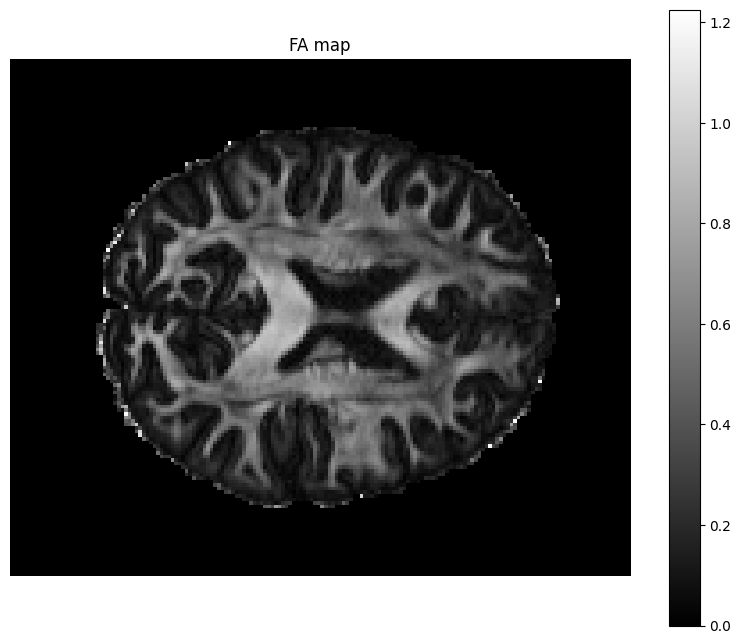

In [7]:
# type: ignore
# Plotting the FA map
plot(FSL.FA, title="FA map")

In [8]:
# add random noise to the FA map
FA_noisy = FSL.FA + 0.2 * FSL.FA.std() * np.random.randn(*FSL.FA.shape)

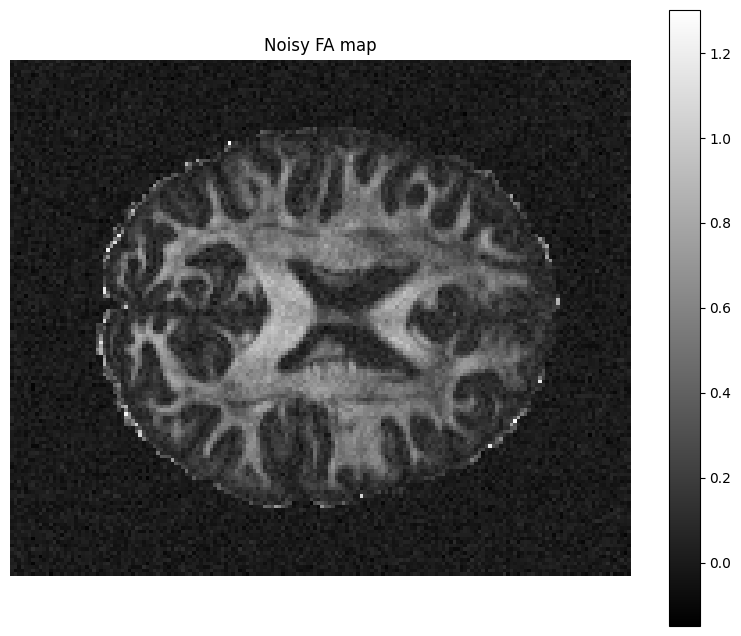

In [9]:
# type: ignore
# Plotting the noisy FA map
plot(FA_noisy, title="Noisy FA map")

In [10]:
def heat_conduction(x: FloatArr) -> FloatArr:
    """
    Heat conduction function for the diffusion tensor.
    Modifies the input array in place.
    """
    # save the indices of all values <= 0
    neg_indices = x <= 0
    pos_indices = ~neg_indices

    # set the values at those indices to 1
    x[neg_indices] = 1

    # set the values of all other indices to 1 - exp(-C_4 / (x[pos_indices] / Lambda) ** m)
    x[pos_indices] = 1 - np.exp(-C_m / ((x[pos_indices] * (1 / Lambda)) ** m))

    return x

In [11]:
img = math.Image(data=FA_noisy.copy())

In [12]:
for _ in range(MAX_ITER):
    smoothed_img = operations.smooth(img, sigma=SIGMA)
    structure_tensor = operations.structure_tensor(smoothed_img, heat_conduction)
    
    img = eed.step(img, structure_tensor, step_size=STEP_SIZE)

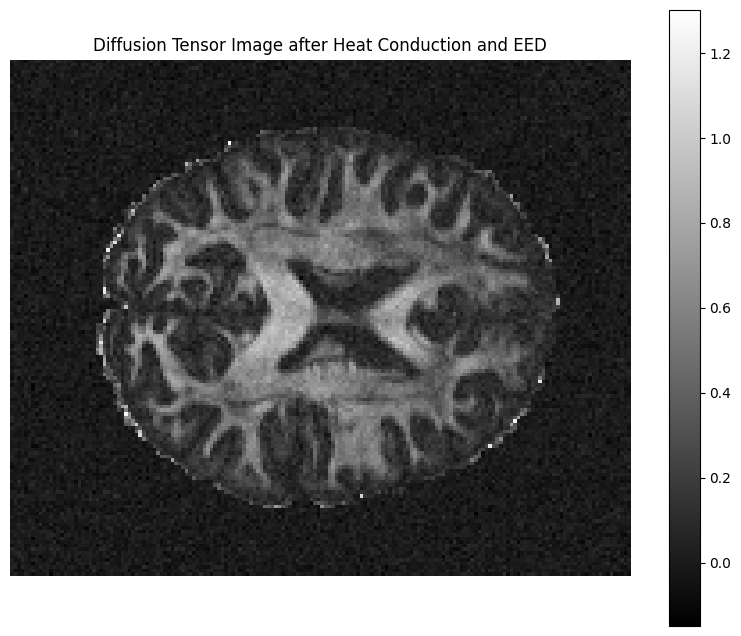

In [13]:
plot(
    img.data,
    title="Diffusion Tensor Image after Heat Conduction and EED",
)

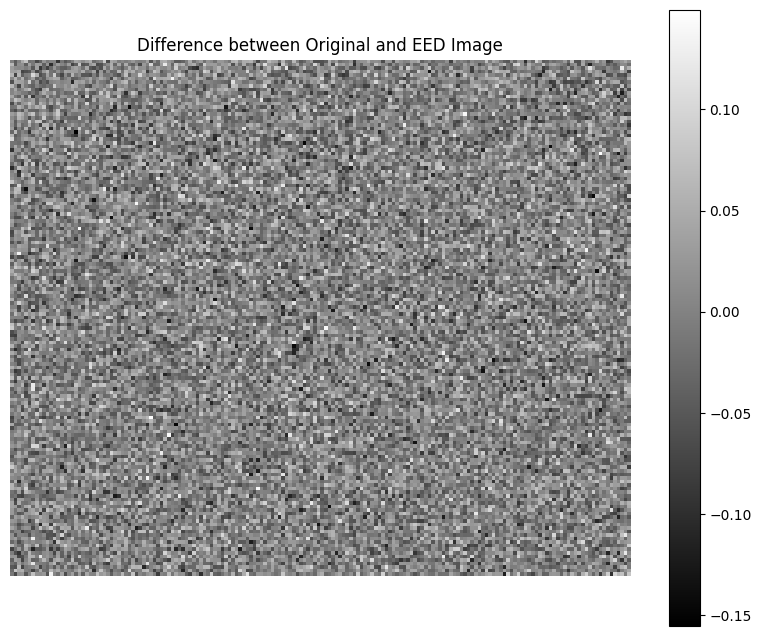

In [14]:
plot(FSL.FA - img.data, title="Difference between Original and EED Image")